In [143]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [144]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../../data/benchmark-cluster/explodingLiquidBiggerSpacing/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if ".csv" not in file:
            continue

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        tuning_algorithm = directory.split("/")[-1]
        thread = directory.split("/")[-2]
        scenario = "explodingLiquid"

        with open(os.path.join(directory, file)) as f:
            print(directory, file)
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not thread in data[scenario]:
            data[scenario][thread] = {}

        if not tuning_algorithm in data[scenario][thread]:
            data[scenario][thread][tuning_algorithm] = {}

        data[scenario][thread][tuning_algorithm][file_type] = df_tuners

Processing AutoPas_tuningData_Rank0_2024-07-02_15-30-35.csv
../../../../data/benchmark-cluster/explodingLiquidBiggerSpacing/1/BayesianClusterSearch AutoPas_tuningData_Rank0_2024-07-02_15-30-35.csv
Processing AutoPas_tuningResults_Rank0_2024-07-02_15-30-35.csv
../../../../data/benchmark-cluster/explodingLiquidBiggerSpacing/1/BayesianClusterSearch AutoPas_tuningResults_Rank0_2024-07-02_15-30-35.csv
Processing AutoPas_iterationPerformance_Rank0_2024-07-02_15-30-35.csv
../../../../data/benchmark-cluster/explodingLiquidBiggerSpacing/1/BayesianClusterSearch AutoPas_iterationPerformance_Rank0_2024-07-02_15-30-35.csv
Processing AutoPas_tuningResults_Rank0_2024-07-08_01-06-59.csv
../../../../data/benchmark-cluster/explodingLiquidBiggerSpacing/1/FuzzyTuning [Suitability] AutoPas_tuningResults_Rank0_2024-07-08_01-06-59.csv
Processing AutoPas_iterationPerformance_Rank0_2024-07-08_01-06-59.csv
../../../../data/benchmark-cluster/explodingLiquidBiggerSpacing/1/FuzzyTuning [Suitability] AutoPas_iterat

# Make Line Plot of Smoothed Value over Iterations


1.0096234606282808
0.9392321627364386
0.900072323473044
0.8602037197733523
0.8497066037830181
0.8427102743938004
0.537769468544288


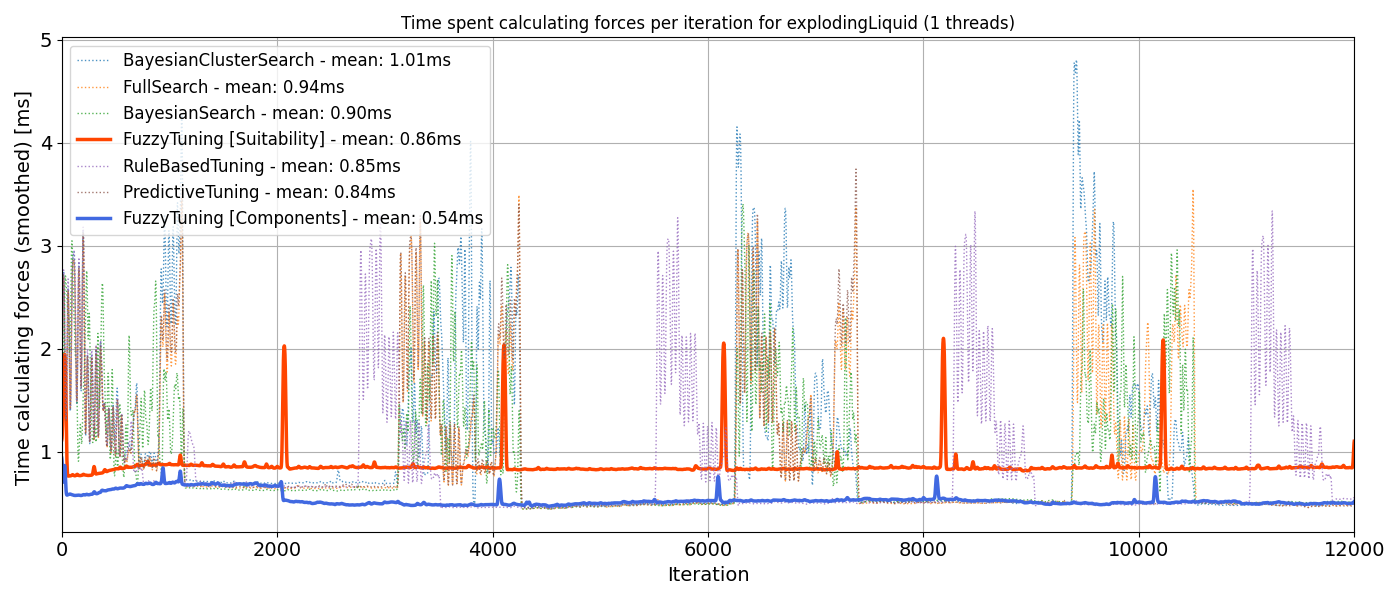

In [145]:
from scipy.signal import lfilter
from tsmoothie.smoother import *

for scenario, s_data in data.items():

    for threads, r_data in sorted(s_data.items()):
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].mean(), reverse=True):

            iteration_data = logs["iterationPerformance"]

            time_s = iteration_data["iteratePairwiseTotal[ns]"] / 1e9

            first_k = 1000000

            x = iteration_data["Iteration"][:first_k]
            y = time_s[:first_k] * 1000

            mean = y.mean()

            print(mean)

            # ax.plot(x, y, label=f"{tuning_algorithm} - mean: {meanNS:.2f}ns")

            if np.logical_or(np.isnan(y), np.isinf(y)).any():
                print(y)
                raise ValueError(f"Found NaN or Inf in {
                                 tuning_algorithm + threads + scenario}")

            smoother = ConvolutionSmoother(
                window_len=40, window_type='blackman')
            smoother.smooth(y)
            low, up = smoother.get_intervals('sigma_interval', n_sigma=0.04)

            linewidth = 2.5 if "Fuzzy" in tuning_algorithm else 1
            opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8
            linestyle = "-" if "Fuzzy" in tuning_algorithm else ":"

            color = ax._get_lines.get_next_color()
            if "Suitability" in tuning_algorithm:
                color = "orangered"
            elif "Components" in tuning_algorithm:
                color = "royalblue"

            # if "Holdout" in tuning_algorithm:
            #     linestyle = "--"

            ax.plot(smoother.smooth_data[0], label=f"{
                    tuning_algorithm} - mean: {mean:.2f}ms", linewidth=linewidth, alpha=opacity, linestyle=linestyle, color=color)

            plt.grid()

        ax.legend(prop={'size': 12})
        ax.set_xlabel("Iteration")
        ax.set_ylabel(
            "Time calculating forces (smoothed) [ms] ")

        ax.set_xlim(0, 12000)

        # set y axis to mikro seconds

        ax.set_title(f"Time spent calculating forces per iteration for {
                     scenario} ({threads} threads)")
        # ax.set_xlim(0, df["Iteration"].max())
        # log

        # make y axis bigger
        ax.yaxis.set_tick_params(labelsize=14)
        ax.xaxis.set_tick_params(labelsize=14)
        # make axis title bigger
        ax.yaxis.label.set_size(14)
        ax.xaxis.label.set_size(14)

        fig.tight_layout()

        #logarithmic scale
        # ax.set_yscale('log')

        plt.show()
        fig.savefig(f"timing_{scenario}_{threads}.png", dpi=300)

# Make bar plots about total time

12001
12001


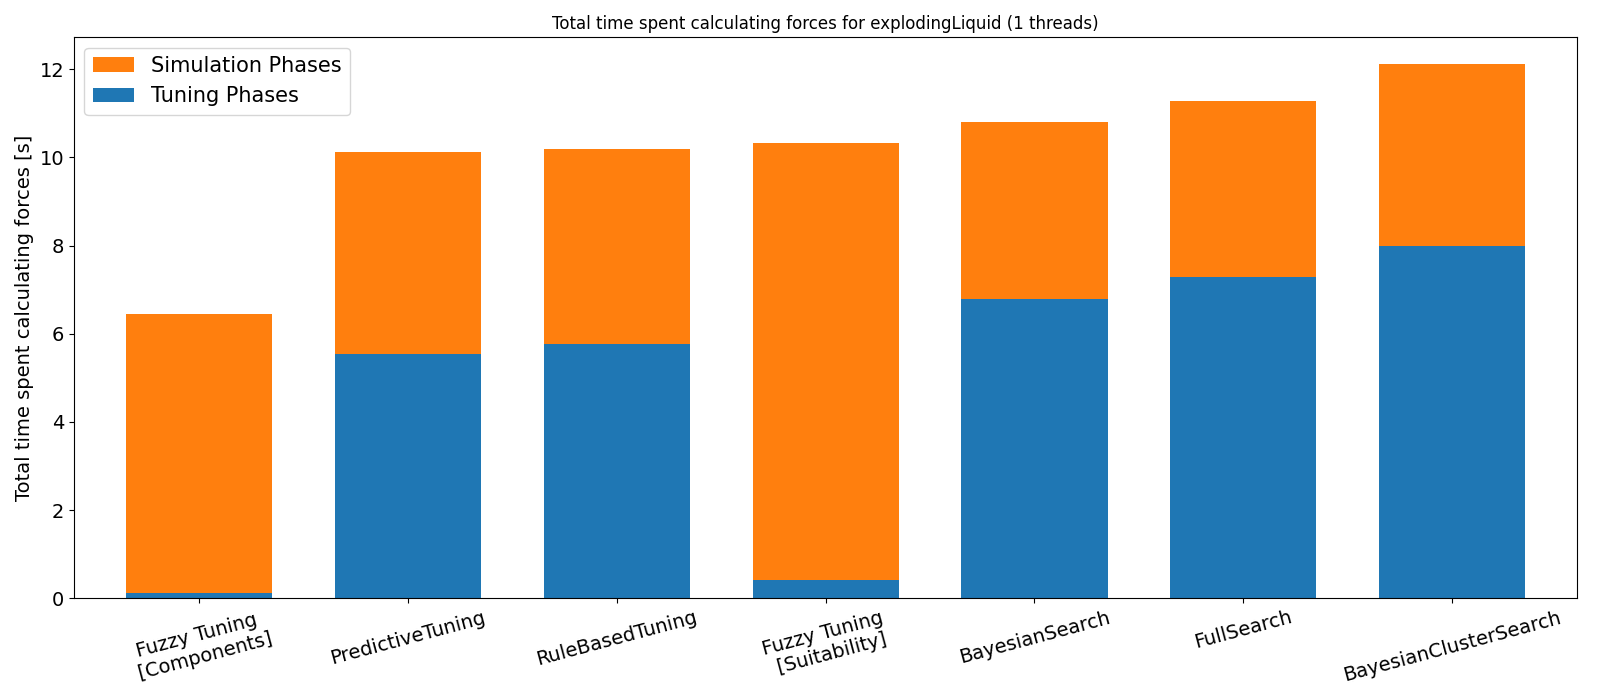

In [146]:
longest_simulation = 0
for scenario, s_data in data.items():

    for threads, r_data in s_data.items():

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

            longest_simulation = max(
                longest_simulation, len(logs["iterationPerformance"]))

print(longest_simulation)


longest_simulation = 0
for scenario, s_data in data.items():

    for threads, r_data in s_data.items():

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

            longest_simulation = max(
                longest_simulation, len(logs["iterationPerformance"]))

print(longest_simulation)


for scenario, s_data in data.items():

    for threads, r_data in sorted(s_data.items(), key=lambda x: x[0]):

        timings = {}

        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() / (len(x[1]["iterationPerformance"]) / longest_simulation), reverse=False):

            # filter logs only include where intuningphase is true
            iteration_data = logs["iterationPerformance"]

            tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
            simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

            tuning_time_s = tuning_iterations["iteratePairwiseTotal[ns]"].sum(
            ) / 1e9
            simulation_time_s = simulation_iterations["iteratePairwiseTotal[ns]"].sum(
            ) / 1e9

            # add newline after "Fuzzy" in name
            if "FuzzyTuning" in tuning_algorithm:
                tuning_algorithm = tuning_algorithm.replace("FuzzyTuning", "Fuzzy Tuning\n")
            if "[Holdout]" in tuning_algorithm:
                tuning_algorithm = tuning_algorithm.replace("[Holdout]", "\n[Holdout]")

            timings[tuning_algorithm] = {
                "Tuning Phases": tuning_time_s,
                "Simulation Phases": simulation_time_s
            }

        # df with tuning algorithm as row
        df = pd.DataFrame(timings).T

        fig, ax = plt.subplots(1, 1, figsize=(16, 7))

        df.plot(kind='bar', stacked=True, ax=ax, width=0.7)

        # tilt x labels
        plt.xticks(rotation=15, fontsize=16)

        ax.set_ylabel("Total time spent calculating forces [s]", fontsize=16)

        ax.set_title(f"Total time spent calculating forces for {
                     scenario} ({threads} threads)")

        handles, lables = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], lables[::-1], prop={'size': 15})

        # make y axis bigger
        ax.yaxis.set_tick_params(labelsize=14)
        ax.xaxis.set_tick_params(labelsize=14)
        # make axis title bigger
        ax.yaxis.label.set_size(14)

        fig.tight_layout()

        #logarithmic scale

        fig.savefig(f"total_time_{scenario}_{threads}.png", dpi=300)
        plt.show()

In [147]:
# Function to add jittered points
def add_jittered_points(data, pos, color, alpha=0.2, vert=True):
    y = data
    x = np.random.normal(pos, 0.1, size=len(y))

    if vert:
        plt.scatter(x, y, color=color, alpha=alpha)
    else:
        plt.scatter(y, x, color=color, alpha=alpha)

12001


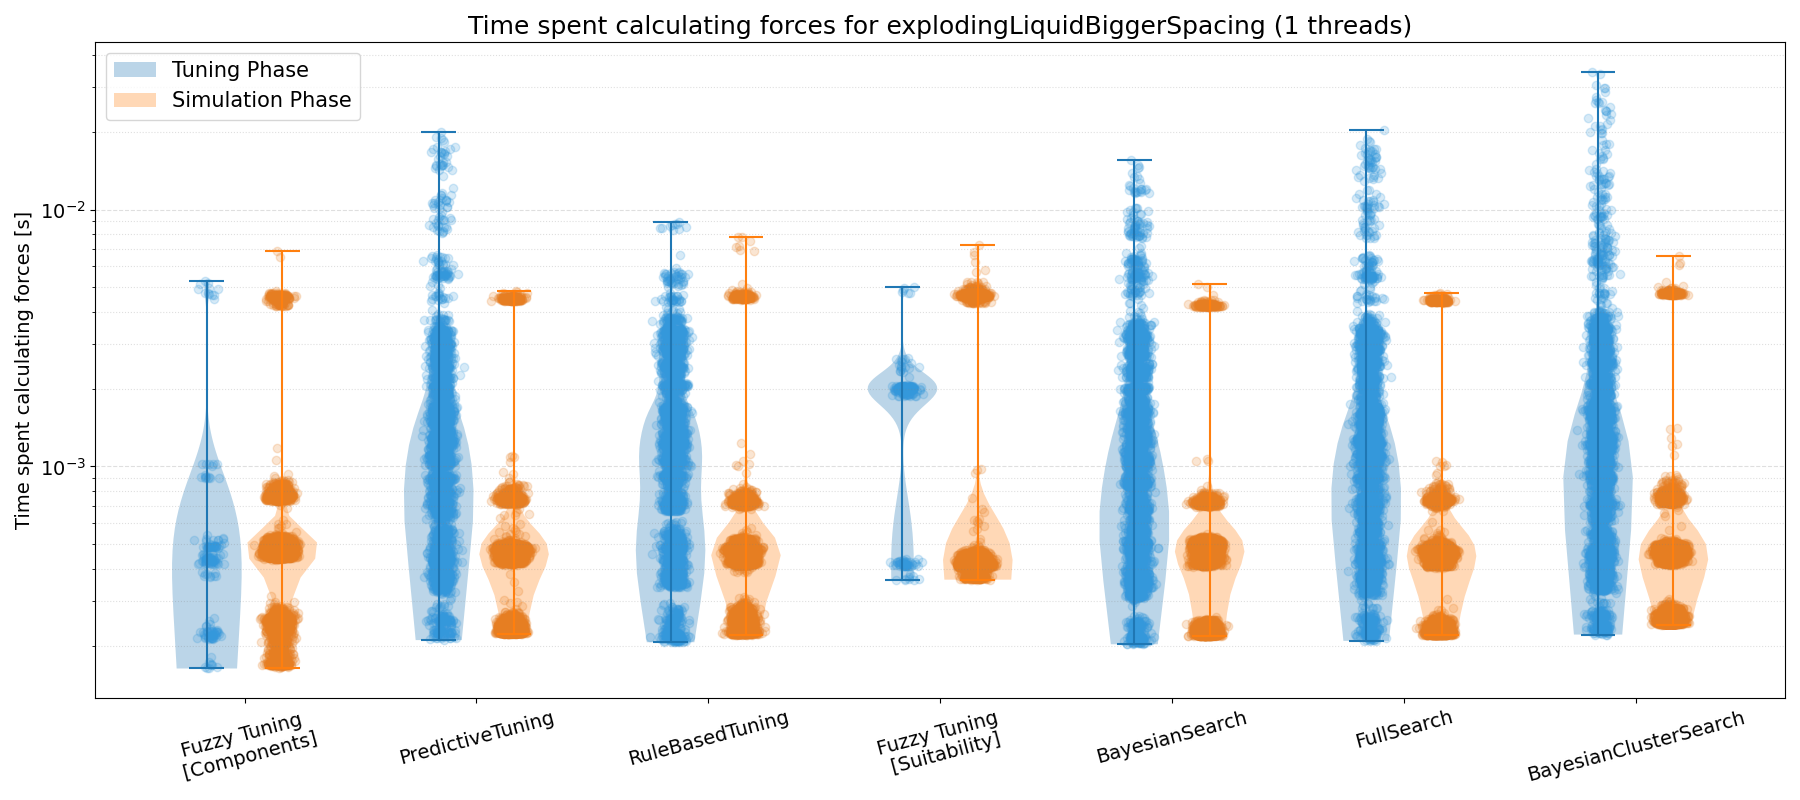

In [148]:
longest_simulation = 0
for scenario, s_data in data.items():

    for threads, r_data in s_data.items():

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum(), reverse=False):

            longest_simulation = max(
                longest_simulation, len(logs["iterationPerformance"]))

print(longest_simulation)

for scenario, s_data in data.items():
    for threads, r_data in sorted(s_data.items(), key=lambda x: x[0]):
        timings = {}
        algorithms = []

        # Collect data
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"].sum() / (len(x[1]["iterationPerformance"]) / longest_simulation), reverse=False):

            # add newline after "Fuzzy" in name
            if "FuzzyTuning" in tuning_algorithm:
                tuning_algorithm = tuning_algorithm.replace(
                    "FuzzyTuning", "Fuzzy Tuning\n")
            if "[Holdout]" in tuning_algorithm:
                tuning_algorithm = tuning_algorithm.replace(
                    "[Holdout]", "\n[Holdout]")

            algorithms.append(tuning_algorithm)
            iteration_data = logs["iterationPerformance"]
            tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]
            simulation_iterations = iteration_data[iteration_data["inTuningPhase"] == False]

            timings[tuning_algorithm] = {
                "Tuning Phases": tuning_iterations["iteratePairwiseTotal[ns]"] / 1e9,
                "Simulation Phases": simulation_iterations["iteratePairwiseTotal[ns]"] / 1e9
            }
        # Create plot
        fig, ax = plt.subplots(figsize=(18, 8))

        # Set positions for boxplots
        # Increased spacing between algorithm groups
        positions = range(0, len(algorithms) * 4, 4)
        width = 1.2  # Increased width of boxes

      
        # Create boxplots with jittered outliers
        bp_tuning = ax.violinplot([timings[alg]["Tuning Phases"] for alg in algorithms],
                                  positions=[p - width/2 -
                                             0.05 for p in positions],
                                  widths=width, )

        bp_simulation = ax.violinplot([timings[alg]["Simulation Phases"] for alg in algorithms],
                                      positions=[p + width/2 +
                                                 0.05 for p in positions],
                                      widths=width)

        # Add scatter plots
        for i, alg in enumerate(algorithms):
            add_jittered_points(
                timings[alg]["Tuning Phases"], positions[i] - width/2, '#3498db')
            add_jittered_points(
                timings[alg]["Simulation Phases"], positions[i] + width/2, '#e67e22')

        # Increase font sizes
        plt.title(
            'Time spent calculating forces for explodingLiquidBiggerSpacing (1 threads)', fontsize=18)
        ax.set_ylabel('Time spent calculating forces [s]', fontsize=16)

        # Rotate x-axis labels
        plt.xticks(rotation=15, fontsize=14)
        plt.yticks(fontsize=14)

        # Use more distinct colors
        for box in bp_tuning['bodies']:
            box.set(facecolor='#1f77b4')
        for box in bp_simulation['bodies']:
            box.set(facecolor='#ff7f0e')  # Orange

        ax.set_xticks(positions)
        ax.set_xticklabels(algorithms, rotation=15)

        # minor grid lines on y
        ax.yaxis.grid(True, linestyle=':', which='minor',
                      color='grey', alpha=.25)

        # Add legend
        ax.legend([bp_tuning["bodies"][0], bp_simulation["bodies"][0]],
                  ["Tuning Phase", "Simulation Phase"], fontsize=15)

        # Logarithmic y-axis
        ax.set_yscale('log')

        # more grid lines
        ax.yaxis.grid(True, linestyle='--', which='major',
                      color='grey', alpha=.25)

        ax.yaxis.set_tick_params(labelsize=14)
        ax.xaxis.set_tick_params(labelsize=14)
        # make axis title bigger
        ax.yaxis.label.set_size(14)

        fig.tight_layout()

        fig.savefig(f"boxplot_{scenario}_{threads}.png", dpi=300)

        plt.show()

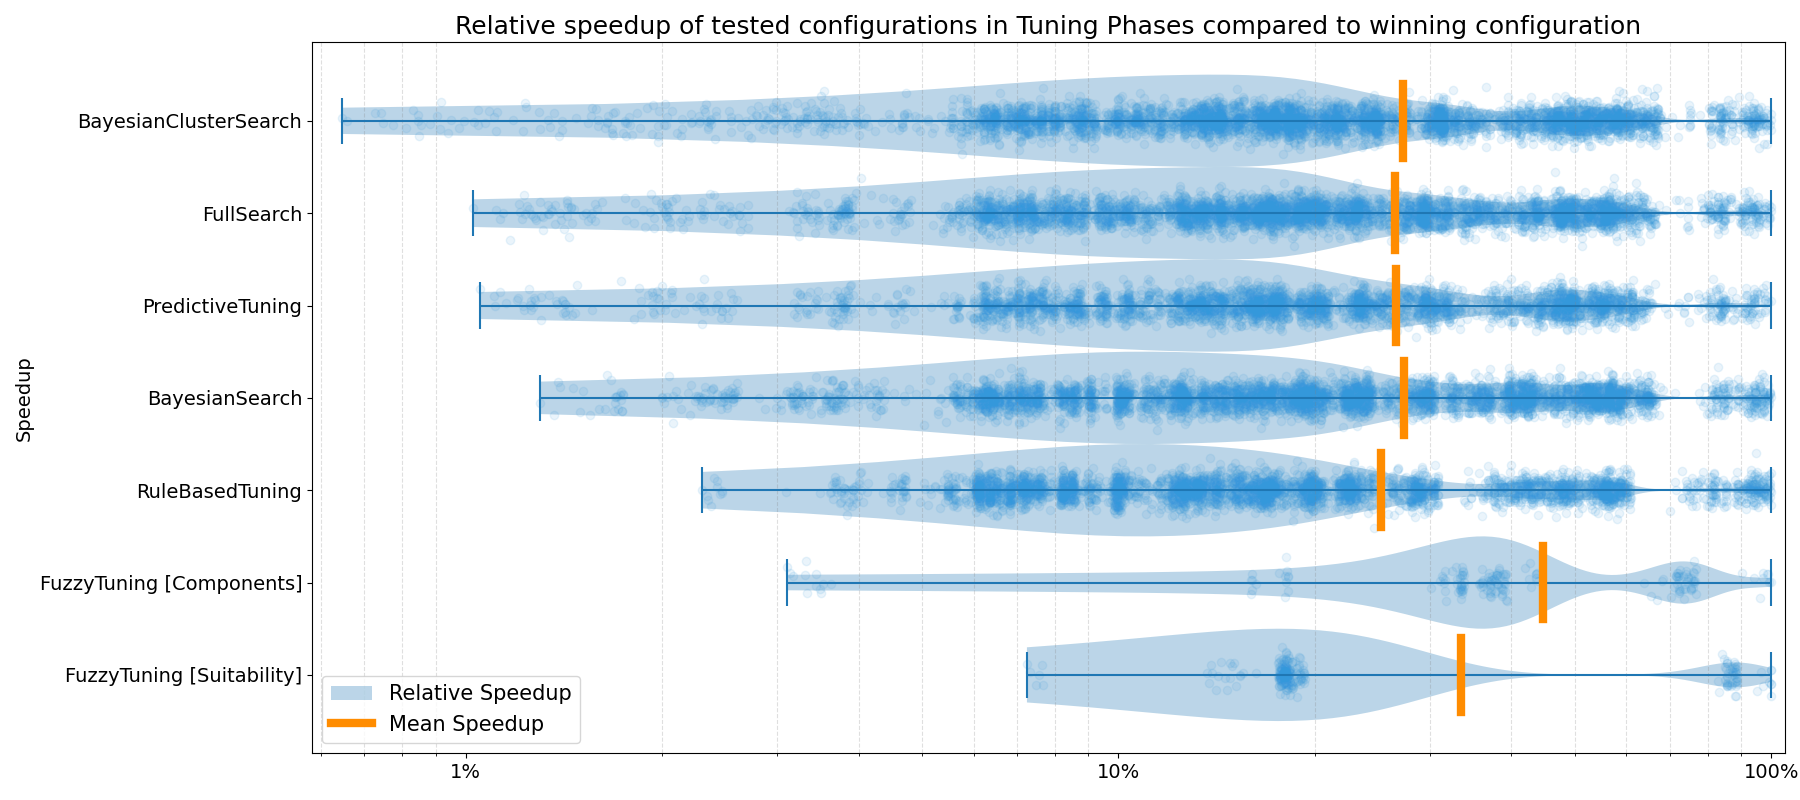

In [150]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
import numpy as np


for scenario, s_data in data.items():

    for threads, r_data in sorted(s_data.items(), key=lambda x: x[0]):
        min_speedup = 1
        speedups = {}
        algorithms = []

        def calc_speedup(x): return x.min() / x

        # Collect data, sort by lowest speedup for tuning phase
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: calc_speedup(x[1]["iterationPerformance"]["iteratePairwiseTotal[ns]"]).min(), reverse=True):
            algorithms.append(tuning_algorithm)
            iteration_data = logs["iterationPerformance"]
            tuning_iterations = iteration_data[iteration_data["inTuningPhase"] == True]

            speedups[tuning_algorithm] = {
                "Speedup": calc_speedup(tuning_iterations["iteratePairwiseTotal[ns]"])
            }

            min_speedup = min(
                min_speedup, speedups[tuning_algorithm]["Speedup"].min())

        fig, ax = plt.subplots(figsize=(18, 8))

        positions = range(0, len(algorithms))
        width = 1  # Increased width of boxes

        bp_tuning = ax.violinplot([speedups[alg]["Speedup"]
                                   for alg in algorithms],
                                  positions=[p for p in positions],
                                  widths=width, vert=False)

        for i, alg in enumerate(algorithms):
            add_jittered_points(
                speedups[alg]["Speedup"], positions[i], '#3498db', vert=False, alpha=0.1)
        # add median lines
        for i, alg in enumerate(algorithms):
            mean = speedups[alg]["Speedup"].mean()
            ax.plot([mean, mean], [positions[i] - 0.4, positions[i] + 0.4],
                    color='darkorange', linewidth=6)

        # Increase font sizes
        plt.title(
            'Relative speedup of tested configurations in Tuning Phases compared to winning configuration', fontsize=18)
        ax.set_ylabel('Speedup', fontsize=16)

        # Rotate x-axis labels

        # Use more distinct colors
        for box in bp_tuning['bodies']:
            box.set(facecolor='#1f77b4')

        ax.set_yticks(positions)

        ax.set_yticklabels(algorithms)

        # minor grid lines on y
        ax.yaxis.grid(True, linestyle=':', which='minor',
                      color='grey', alpha=.25)

        # Add legend
        ax.legend([bp_tuning["bodies"][0], Line2D([0], [0], color='darkorange', lw=6)],
                  ["Relative Speedup", "Mean Speedup"], fontsize=15)

        # Logarithmic y-axis
        ax.set_xscale('log')

        # more grid lines
        ax.xaxis.grid(True, linestyle='--', which='minor',
                      color='grey', alpha=.25)

        ax.yaxis.set_tick_params(labelsize=14)
        ax.xaxis.set_tick_params(labelsize=14)
        # make axis title bigger

        ax.yaxis.label.set_size(14)

        fig.tight_layout()

        fig.savefig(f"tuning_phase_speedup_{scenario}_{threads}.png", dpi=300)

        # limit x axis to 1
        ax.set_xlim(min_speedup*0.9, 1.05)

        # y label percent
        ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

        fig.savefig(f"tuning_phase_speedup_{scenario}_{threads}_zoomed.png", dpi=300)